In [13]:
# Setup

import pandas as pd
from pathlib import Path
import hvplot.pandas
import requests
import json
from pprint import pprint
from config import geoapify_key
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

# Import and read files

file = Path("data/merged_df.csv")
df = pd.read_csv(file, encoding="utf-8")

df = df.drop("Unnamed: 0", axis=1)

In [14]:
# Group by country

by_country = df.groupby(["Country"])

avg_cagr = by_country["CAGR (%)"].mean()
number_startups = by_country.size()

country_df = pd.DataFrame({
    "Avg CAGR (%)": avg_cagr,
    "Number of Startups": number_startups
})

# Sort df

country_df = country_df.sort_values(by="Avg CAGR (%)", ascending = False)
country_df = country_df.reset_index()

country_df

,Country,Avg CAGR (%),Number of Startups
0,Lithuania,18.465000,2
1,Belgium,7.373333,3
2,Estonia,5.772000,5
3,Singapore,4.914615,13
4,Turkey,4.800000,3
5,Australia,3.248750,8
6,United States,2.386799,581
7,Israel,2.146667,18
8,South Korea,1.925385,13
9,Germany,1.018846,26


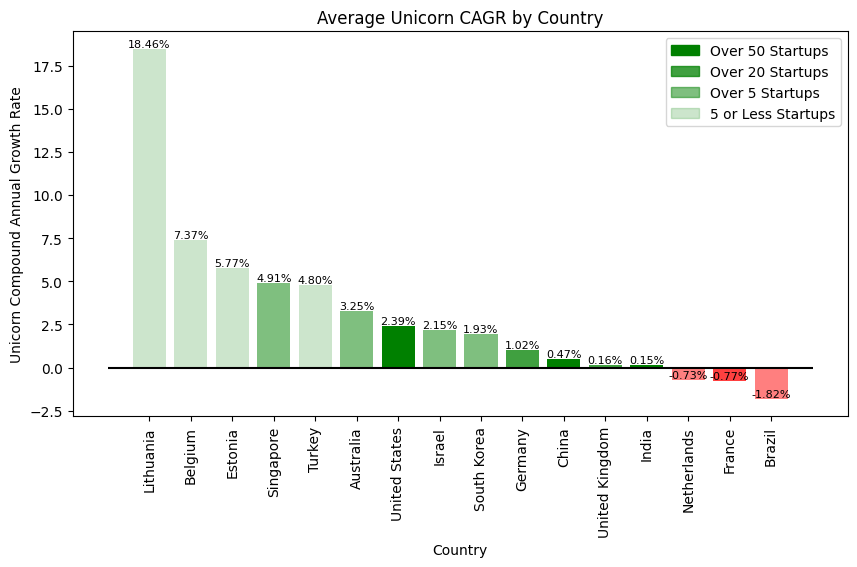

In [15]:
# Bar plot

# Filter out 0% CAGRs

country_df = country_df[country_df["Avg CAGR (%)"] != 0]

# Bar plot setup

countries = country_df["Country"].tolist()
cagr = country_df["Avg CAGR (%)"]
count = country_df["Number of Startups"]

plt.figure(figsize=(10, 5))

x_axis = np.arange(len(countries))
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, countries, rotation=90)

colors = ["green" if x > 0 else "red" if x < 0 else "black" for x in cagr]
alphas = [1 if x > 50 else 0.75 if x > 20 else 0.5 if x > 5 else 0.2 for x in count]

bars = plt.bar(x_axis, cagr, 
               color=colors
               )

for bar, alpha in zip(bars, alphas):
    bar.set_alpha(alpha)

# Data labels

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}%",
             ha="center", va="bottom", fontsize=8, color="black")

# Horizontal line at 0

plt.hlines(0, -1, len(countries), color="black")

# Chart labels

plt.xlabel("Country")
plt.ylabel("Unicorn Compound Annual Growth Rate")
plt.title("Average Unicorn CAGR by Country")

# Custom legend

legend_handles = [mpatches.Patch(color="green", alpha=1, label="Over 50 Startups"),
                  mpatches.Patch(color="green", alpha=0.75, label="Over 20 Startups"),
                  mpatches.Patch(color="green", alpha=0.5, label="Over 5 Startups"),
                  mpatches.Patch(color="green", alpha=0.2, label="5 or Less Startups")
                 ]

plt.legend(handles=legend_handles)

# Save fig

plt.savefig("visuals/cagr_by_country.png", bbox_inches="tight", dpi=300, transparent=True)

plt.show()

Slope: -1.5959690837392233. R value: -0.4985078143583316. P value: 0.06961835673188947.
17.071428571428573


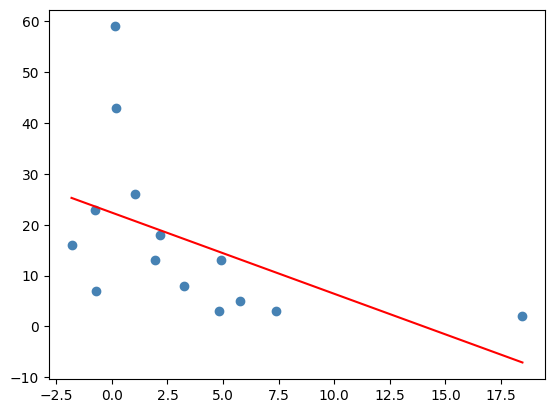

In [16]:
# Linear Regression between number of startups and CAGR - excluding outliers (U.S. and China)

from scipy import stats
from scipy.stats import linregress

country_df = country_df[country_df["Country"] != "United States"]
country_df = country_df[country_df["Country"] != "China"]

x_axis = country_df["Avg CAGR (%)"]
y_axis = country_df["Number of Startups"]

plt.scatter(x_axis, y_axis, marker="o", facecolors="steelblue", edgecolors="steelblue")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
plt.plot(x_axis, regress_values, "r-")

print(f"Slope: {slope}. R value: {rvalue}. P value: {pvalue}.")
print(f"{country_df['Number of Startups'].mean()}")

plt.savefig("visuals/cagr_linear_regress.png", bbox_inches="tight", dpi=300)

plt.show()

Exponential Model Parameters: a = 23.583740524743313, b = -0.14193175603024474


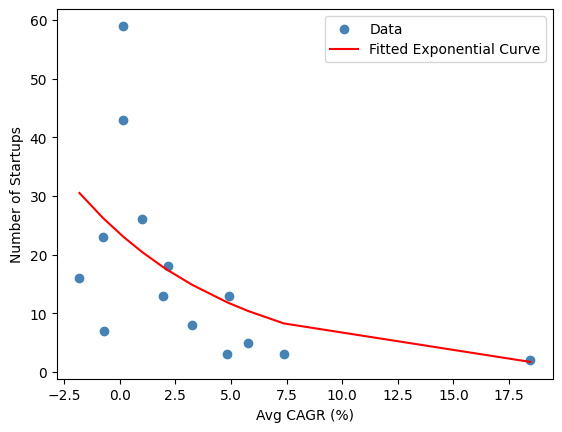

In [17]:
# Trying an exponential regression

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the exponential function
def exponential_model(x, a, b):
    return a * np.exp(b * x)

country_df = country_df[country_df["Country"] != "United States"]
country_df = country_df[country_df["Country"] != "China"]

# Prepare your data
x_axis = country_df["Avg CAGR (%)"]
y_axis = country_df["Number of Startups"]

# Fit the exponential curve
params, covariance = curve_fit(exponential_model, x_axis, y_axis)

# Extract parameters
a, b = params
print(f"Exponential Model Parameters: a = {a}, b = {b}")

# Predict values using the fitted model
fitted_values = exponential_model(x_axis, a, b)

# Plot the data and fitted curve
plt.scatter(x_axis, y_axis, marker="o", color="steelblue", label="Data")
plt.plot(x_axis, fitted_values, color="red", label="Fitted Exponential Curve")
plt.xlabel("Avg CAGR (%)")
plt.ylabel("Number of Startups")
plt.legend()

plt.savefig("visuals/cagr_exp_regress.png", bbox_inches="tight", dpi=300)

plt.show()

In [18]:
# Evaluate exponential regression

from sklearn.metrics import r2_score, mean_squared_error

# Calculate R-squared and MSE
r2 = r2_score(y_axis, fitted_values)
mse = mean_squared_error(y_axis, fitted_values)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.28688206748138956
Mean Squared Error: 179.9567656137908
